<a href="https://colab.research.google.com/github/Soso925/mini-dl-projects/blob/master/final_version_pneumonia_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Images (Pneumonia) 



# Set up 

In [0]:
#@title Kaggle set up to download data 
!pip install kaggle

# cp kaggle.json
!mkdir ~/.kaggle
!cp '/content/drive/My Drive/kaggle/kaggle.json' ~/.kaggle/kaggle.json

#!kaggle datasets list 
# download pneumonia 
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
# unzip and rm redundant ds 
!unzip \*.zip
!rm -rf '/content/chest_xray/chest_xray/'




In [1]:
#@title import libs 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt 
import cv2 
import pickle 

import tensorflow as tf 
import keras 
from keras.models import Input, Model 
from keras.layers import Dense,Lambda, Dropout, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
import random 



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#@title params 
dir_train = '/content/chest_xray/train/'
dir_test = '/content/chest_xray/test/'
dir_val = '/content/chest_xray/val/'

pneu = 'PNEUMONIA'
normal = 'NORMAL'

np.random.seed(2020) 

h, w = 924, 1268
prop = 0.25
new_h, new_w = int(h*prop), int(w*prop)
chan = 3
batchSize = 32
ep = 10

gm_exp = 3.0 # useful for function generalized_mean_pool_2d

# EDA

In [3]:
# size of each dir  
!ls '/content/chest_xray/train/PNEUMONIA/' | wc -l
!ls '/content/chest_xray/train/NORMAL/' | wc -l
!ls '/content/chest_xray/test/PNEUMONIA/' | wc -l
!ls '/content/chest_xray/test/NORMAL/' | wc -l
!ls '/content/chest_xray/val/PNEUMONIA/' | wc -l
!ls '/content/chest_xray/val/NORMAL/' | wc -l

3875
1341
390
234
8
8


Train set total cases : 5216      
PNEUMONIA cases : 3875, NORMAL cases : 1341.


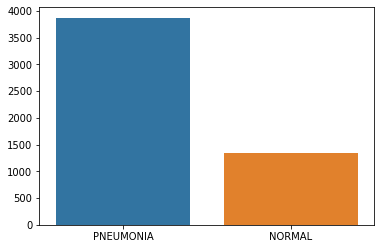

In [4]:
#@title get some train image filepaths for plot 
dict_train = {}
for suffix in ['PNEUMONIA', 'NORMAL']:
    list = []
    for dirname, _, filenames in os.walk(os.path.join(dir_train,suffix)):
        for filename in filenames:
            list.append(os.path.join(dir_train,suffix, filename))
    dict_train[suffix] = list

print(f'Train set total cases : {len(dict_train["PNEUMONIA"])+len(dict_train["NORMAL"])}\
      \nPNEUMONIA cases : {len(dict_train["PNEUMONIA"])}, NORMAL cases : {len(dict_train["NORMAL"])}.')

sns.barplot(x = ['PNEUMONIA', 'NORMAL'], y = [len(dict_train["PNEUMONIA"]),len(dict_train["NORMAL"])],)

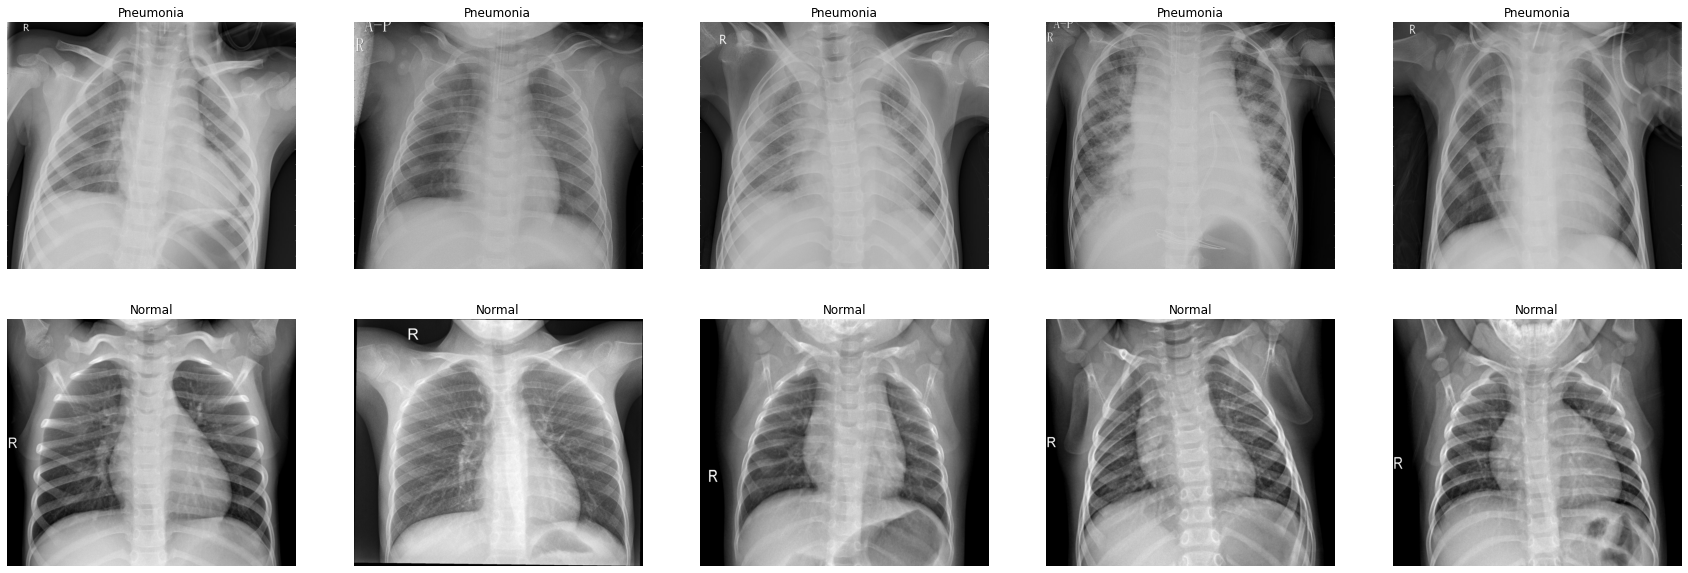

In [5]:
#@title plot first 5 cases in pneu and normal 

def plot_img(list_img_pneu, list_img_normal): 
    fig, ax = plt.subplots(2,5, figsize=(30,10))

    for i in range(10):
        #img = imread(samples[i])
        #ax[i//5, i%5].imshow(img, cmap='gray')
        if i<5:
            img = cv2.imread(list_img_pneu[i])
            ax[i//5, i%5].imshow(img,cmap='gray')
            ax[i//5, i%5].set_title("Pneumonia")
        else:
            img = cv2.imread(list_img_normal[i-5])
            ax[i//5, i%5].imshow(img,cmap='gray')
            ax[i//5, i%5].set_title("Normal")
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_aspect('auto')
    plt.show()
# example 
plot_img(dict_train['PNEUMONIA'],dict_train['NORMAL'])

# Model

In [0]:
#@title functions of metric and create model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

def modelVGG19(input_shape = (924, 1268,3),  dropout = 0):
    # Input Layer
    inputs = Input(shape = input_shape)
    
    x_model = keras.applications.vgg19.VGG19(weights='imagenet', include_top = False, input_tensor = inputs, pooling = None, classes = None)
    x = x_model.layers[-1].output # take a temporary output block1c_add"
    x = Dropout(dropout)(x)
 
    lambda_layer = Lambda(generalized_mean_pool_2d, name = 'GeM')  
    x = lambda_layer(x)

    x = Dense(16, activation = 'relu', name = 'before_y')(x)

    y = Dense(1, activation = 'sigmoid', name = 'output_y')(x)
    # output
    # model
    model = Model(inputs = x_model.input, outputs = y)
    for i in model.layers:
        i.trainable = True 
    return model


# Train

In [7]:
#@title Image Generator 

from keras.preprocessing.image import ImageDataGenerator
#data generator 

train_datagen = ImageDataGenerator(
        samplewise_center = True, 
        samplewise_std_normalization = True,
        rotation_range = 30, 
        zoom_range = 0.2, 
        horizontal_flip=False)

test_datagen = ImageDataGenerator(        
        samplewise_center = True, 
        samplewise_std_normalization = True)#)

train_generator = train_datagen.flow_from_directory(
        dir_train,
        target_size = (new_h,new_w),
        batch_size = batchSize,
        class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
        dir_val,
        target_size = (new_h,new_w),
        batch_size = batchSize,
        class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
model = modelVGG19(input_shape=(new_h,new_w,chan), dropout = 0.3) 
model.compile(optimizer = Adam(learning_rate = 0.00005),
          loss = 'binary_crossentropy',
          metrics = ['accuracy', f1_m] #, 
          )

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 231, 317, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 231, 317, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 231, 317, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 115, 158, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 115, 158, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 115, 158, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 57, 79, 128)       0   

In [10]:
#@title: Train
# Compile model
path = '/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6'

try:
    os.mkdir(path)
except OSError:

    print ("Creation of the directory %s failed" % path)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                         patience=3, min_lr=0.000001)

mcp = ModelCheckpoint(os.path.join(path,'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), 
                      monitor='val_loss', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='min', period=1)

early_stopping = EarlyStopping(monitor='loss', min_delta=0.0008, patience=1, verbose=0, mode='min',
                                restore_best_weights=False)

history = model.fit_generator(train_generator,
        steps_per_epoch= int(len(train_generator)),
        epochs= ep,
        validation_data=validation_generator,
        callbacks=[reduce_lr, mcp]) #
with open(os.path.join(path, 'histories.pickle'), 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
163/163 [==============================] - 133s 813ms/step - loss: 0.2543 - accuracy: 0.8850 - f1_m: 0.9208 - val_loss: 0.3065 - val_accuracy: 0.8125 - val_f1_m: 0.8421
Epoch 2/10
163/163 [==============================] - 131s 803ms/step - loss: 0.1135 - accuracy: 0.9569 - f1_m: 0.9705 - val_loss: 0.5535 - val_accuracy: 0.6250 - val_f1_m: 0.7273
Epoch 3/10
163/163 [==============================] - 130s 797ms/step - loss: 0.0977 - accuracy: 0.9641 - f1_m: 0.9756 - val_loss: 0.6826 - val_accuracy: 0.7500 - val_f1_m: 0.8000
Epoch 4/10
163/163 [==============================] - 130s 799ms/step - loss: 0.0618 - accuracy: 0.9783 - f1_m: 0.9848 - val_loss: 0.2080 - val_accuracy: 0.8750 - val_f1_m: 0.8889
Epoch 5/10
163/163 [==============================] - 131s 802ms/step - loss: 0.0586 - accuracy: 0.9772 - f1_m: 0.9842 - val_loss: 0.3684 - val_accuracy: 0.8125 - val_f1_m: 0.8421
Epoch 6/10
163/163 [==============================] - 130s 795ms/step - loss: 0.0611 - accuracy: 0.9

In [11]:
#!ls '/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_shear'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6/weights.01-0.31.hdf5
/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6/weights.04-0.21.hdf5
/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6/weights.08-0.08.hdf5
/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6/histories.pickle


# Model Analysis

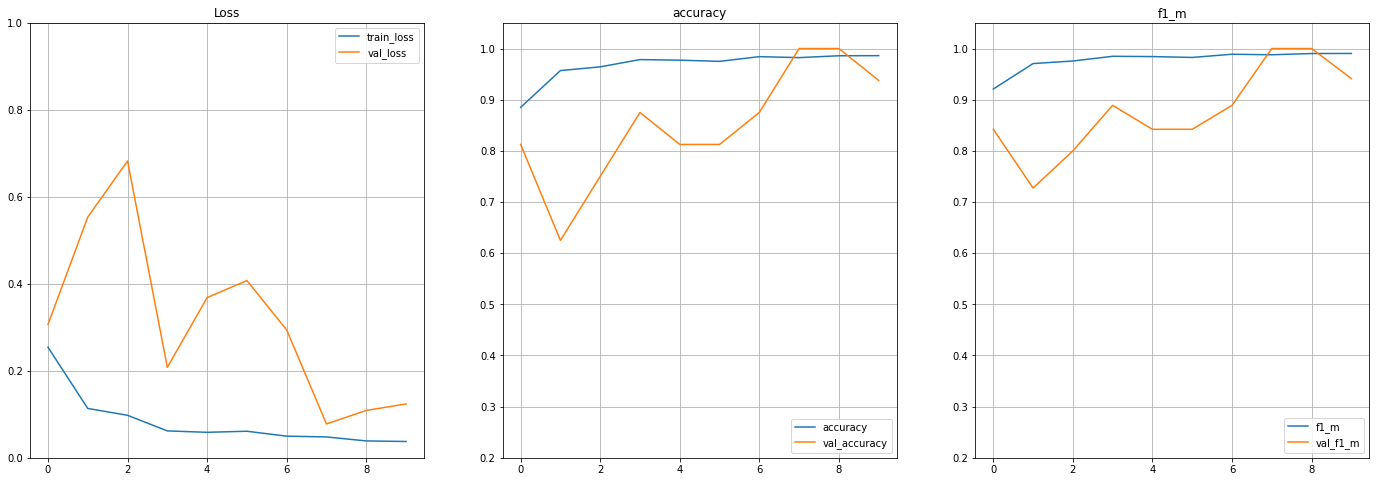

In [12]:
#@title Plot history 

def plot_history(history, variables, nrow = 1, ncol = 3):
        # Plot loss and Accuracy 
    fig, ax = plt.subplots(nrow, ncol, figsize = (8*ncol,8*nrow))
    df = pd.DataFrame(history)
    ax[0].plot(df[['loss','val_loss']])
    ax[0].set_ylim(0, 1)
    ax[0].set_title('Loss')
    ax[0].legend(['train_loss','val_loss'],
                loc='upper right')
    ax[0].grid()
    fig.savefig('loss')
    
    for i in range(len(variables)):
        tmp = str(variables[i])
        val_tmp = 'val_' + tmp 
    
        ax[i+1].plot(df[[tmp,val_tmp]])
        ax[i+1].set_ylim(0.2, 1.05)
        ax[i+1].set_title(tmp)
        ax[i+1].legend([tmp,val_tmp],
                     loc='lower right')
        ax[i+1].grid()
        fig.savefig(tmp)

plot_history(history.history, ['accuracy','f1_m'])

Found 624 images belonging to 2 classes.
[[214  20]
 [ 15 375]]


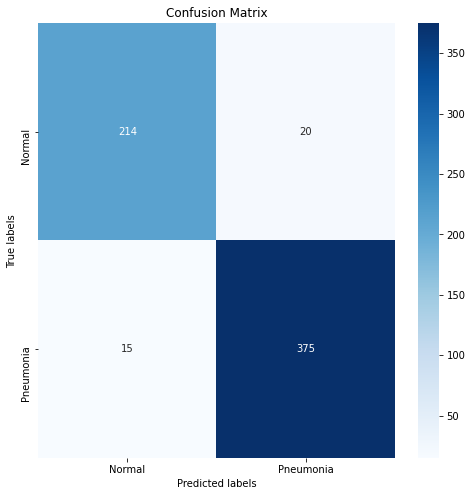

In [18]:
#@title confusion matrix
weight_reload = True
weight_path = '/content/drive/My Drive/kaggle/Pneumonia/VGG19_result_v6/weights.08-0.08.hdf5'

test_generator = test_datagen.flow_from_directory(
        dir_test,
        target_size = (new_h,new_w),
        batch_size = batchSize,
        class_mode = 'binary',
        shuffle=False)
if weight_reload:
    model.load_weights(weight_path) 

prediction = model.predict_generator(test_generator)
y_true = test_generator.classes

cm = confusion_matrix(y_true, np.round(prediction))
print(cm.astype(int))

   

fig, ax = plt.subplots(1, 1, figsize = (8,8))

sns.heatmap(cm, annot=True,cmap='Blues', fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);

fig.savefig(os.path.join(path,'cm.png'))


In [0]:
#@title Define class CAM 

class CAM : 
    def __init__(self, model, classIdx,layerName = None ):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
        
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.") 
        
    def calculate_heatmap(self, image):
        last_conv_layer = self.model.get_layer(self.layerName)
        class_output = self.model.output[:, int(self.classIdx) ] # N* one of classes 
        #print(class_output.shape)
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pool_grads = K.mean(grads, axis = (0,1,2)) # pool the gradients on each axis except for channel 
        iterate = K.function([self.model.input],[pool_grads, last_conv_layer.output[0]])
        grad_values, conv_output_values = iterate([image])
        
        nfeature = self.model.get_layer(self.layerName).output.shape[-1]
        
        for i in range(nfeature):
            conv_output_values [:,:,i] *= grad_values[i]
        heatmap = np.mean(conv_output_values,axis = -1)
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap/heatmap.max()
        return heatmap 
        


In [20]:
ftest = cv2.imread(dir_test + 'PNEUMONIA/person100_bacteria_479.jpeg') 
# Examples : 'PNEUMONIA/person97_bacteria_468.jpeg', NORMAL/IM-0006-0001.jpeg
ft_resized = cv2.resize(ftest,(new_w,new_h),interpolation = cv2.INTER_AREA)

Std, Mean  = ftest.std(), ftest.mean()

ft_transformed = (ftest - Mean)/Std 

ft_tResized = cv2.resize(ft_transformed,(new_w,new_h),interpolation = cv2.INTER_AREA)
ft_tResized2 = ft_tResized.reshape(1,new_h,new_w,chan)
ft_topred = np.expand_dims(ft_tResized, axis=0)

model.predict(ft_tResized2)
model.predict(ft_topred)

array([[0.9998696]], dtype=float32)

In [0]:
cam = CAM(model, 0)
hm = cam.calculate_heatmap(ft_topred)
#cam.overlay_heatmap(hm,hm)

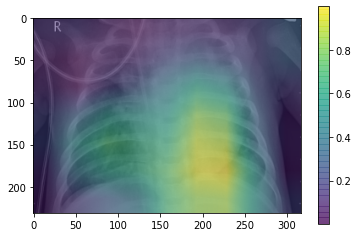

In [22]:
hm = cv2.resize(hm, (new_w,new_h))
plt.imshow(ft_resized)
plt.imshow(hm, alpha = 0.5)
plt.colorbar()
plt.show()
